In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import odeint

In [8]:
# Physical constant
e = 1.6e-19 #[C] electron charge 
M_i = 32*1.6605e-27 #[kg] ion mass
M_n = 32*1.6605e-27 #[kg] ion mass
m = 9.11e-31 #[kg] electron mass
k = 1.38e-23 #[m2 kg /s2 K] Boltzmann constant

# Experimental constant
p = 10/7.5 #[mTorr to Pa]
R = 3e-2 #[m] plasma half-width
L = 33e-2 #[m] chamber length
Tg = 300 #[K] gas temperature
R_0 = 2.5e-2 #[m] chosen normalization length
B_0 = 0.03 #[T] magnetic field
gamma = 20 # electron-ion temperature ratio Te/Ti
Te = 5 #[eV] electron temperature
Ti = Te/gamma
Tn = Ti
n_g = p/k/Tg #[m-3] neutral gas density
n_e0 = n_g * 2.75e-4 #experimental condition
alpha_0 = 1
n_n0 = alpha_0*n_e0
Cs = np.sqrt(e*Te/M_i)
print('n_g :', n_g)
print('n_e0 :', n_e0)
print('n_n0 :', n_n0)

n_g : 3.22061191626409e+20
n_e0 : 8.856682769726248e+16
n_n0 : 8.856682769726248e+16


In [9]:
class fluid_model():
    def calculation(self, eqn, x):
        n_e = eqn[0]
        n_n = eqn[1]
        v_i = eqn[2]
        v_e = eqn[3]
        v_n = eqn[4]
        phi = eqn[5]
        
        K_iz =  2.34e-15*Te**1.03*np.exp(-12.29/Te) #[m3/s]
        K_att = 1.07e-15*Te**-1.391*np.exp(-6.26/Te) #[m3/s]
        K_rec = 5.2e-14*(0.026/Ti)**0.44 #[m3/s]
        nu_i = 3.95e-16*n_g #[s-1]
        nu_e = 4.7e-14*Te**0.5*n_g #[s-1]
        nu_n = 3.95e-16*n_g #[s-1]
        
        w_ce = e*B_0/m
        Di = e*Ti/(M_i*nu_i)
        nu_L = 2*Di/(R*L)*(1+Te/Ti)**0.5
        
        Cs = np.sqrt(e*Te/M_i)
        #### np.linalg.solve 활용해보기
        
        M = np.array([[v_e, 0, 0, n_e, 0, 0],
                      [v_i, v_i, (n_e+n_n), 0, 0, 0],
                      [0, v_n, 0, 0, n_n, 0],
                      [1, 0, 0, 0, 0, -n_e/Te], 
                      [v_i**2+e*Ti/M_i, v_i**2+e*Ti/M_i, 2*(n_e+n_n)*v_i, 0, 0, e*(n_e+n_n)/M_i],
                      [0, v_n**2+e*Tn/M_n, 0, 0, 2*n_n*v_n, -e*n_n/M_n]])

        RHS = np.array([[(K_iz-K_att)*n_g*n_e-nu_L*(n_e+n_n)],
                        [K_iz*n_g*n_e-K_rec*(n_e+n_n)*n_n-nu_L*(n_e+n_n)],
                        [K_att*n_g*n_e-K_rec*(n_e+n_n)*n_n],
                        [-((K_iz*n_g+K_att*n_g+nu_e)*n_e*v_e*m/(e*Te) + w_ce**2/(K_iz*n_g+K_att*n_g+nu_e)*n_e*v_e*m/(e*Te))],
                        [-nu_n*(n_e+n_n)*v_i],
                        [-nu_n*n_n*v_n]])
        
        result = np.reshape(np.linalg.solve(M,RHS),(6,))
        
        return result

    
    def integration(self):
        init = [n_e0, n_n0, 2*Cs, 0.5*Cs, 0.5*Cs, -Te] #E, N, U, V, W, Phi        #U,V,W,Phi 초기값은 바꿔야할듯
        self.x = np.linspace(0,2*R,1000)
        ans = odeint(self.calculation, init, self.x, rtol=10**-3, mxstep=10**6)
        print(ans)
        self.sol_E = ans[:,0]
        self.sol_N = ans[:,1]
        self.sol_I = ans[:,0]+ans[:,1]
        self.sol_U = ans[:,2]
        self.sol_V = ans[:,3]
        self.sol_W = ans[:,4]
        self.sol_Phi = ans[:,5]
        
    def visualize(self):
        plt.figure(figsize=(16,8))
        
        plt.plot(self.x, self.sol_E)
        plt.plot(self.x, self.sol_N)
        plt.plot(self.x, self.sol_I)
        #plt.plot(self.x, self.sol_Phi)
        plt.xlabel('Normalized position')
        plt.ylabel('Normalized densities')
        plt.legend(['Electron','Negative','Positive'])
        #plt.ylim(0,1)
        plt.grid(True)
        
#         plt.subplot(422)
#         plt.plot(self.X, self.sol_N)
#         plt.xlabel('Normalized x')
#         plt.ylabel('Normalized density(N)')
#         plt.grid(True)
#         plt.subplots_adjust(hspace = 0.5)
        
#         plt.show()

[[ 8.85668277e+16  8.85668277e+16  7.76033662e+03  1.94008415e+03
   1.94008415e+03 -5.00000000e+00]
 [ 7.73727130e+16  9.94966624e+16  7.78102031e+03  2.24158781e+03
   1.72680151e+03 -5.09616772e+00]
 [ 6.68201135e+16  1.10043883e+17  7.78909144e+03  2.61655747e+03
   1.56140536e+03 -5.15704108e+00]
 ...
 [            nan             nan             nan             nan
              nan             nan]
 [            nan             nan             nan             nan
              nan             nan]
 [            nan             nan             nan             nan
              nan             nan]]


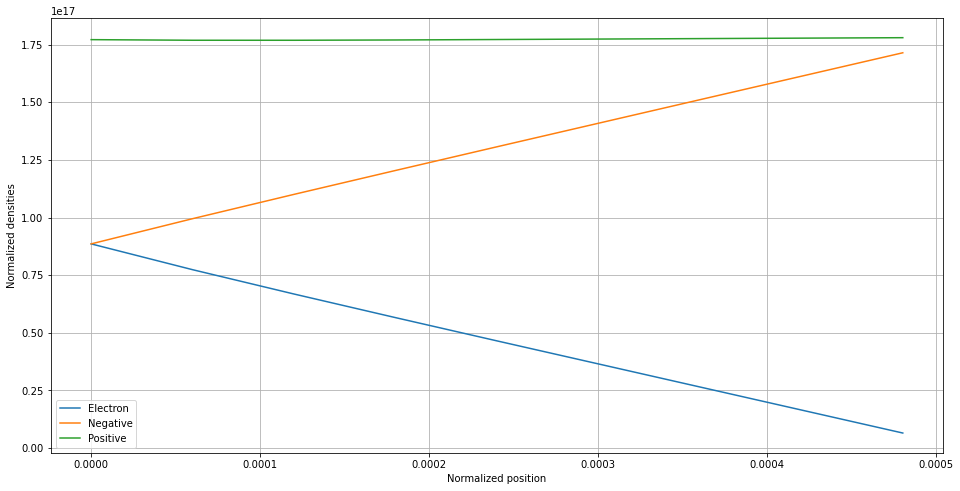

In [10]:
test_model = fluid_model()
test_model.integration()
test_model.visualize()
#test_model.visualize()

In [17]:
np.linalg.solve?

Signature: np.linalg.solve(a, b)
Docstring:
Solve a linear matrix equation, or system of linear scalar equations.

Computes the "exact" solution, `x`, of the well-determined, i.e., full
rank, linear matrix equation `ax = b`.

Parameters
----------
a : (..., M, M) array_like
    Coefficient matrix.
b : {(..., M,), (..., M, K)}, array_like
    Ordinate or "dependent variable" values.

Returns
-------
x : {(..., M,), (..., M, K)} ndarray
    Solution to the system a x = b.  Returned shape is identical to `b`.

Raises
------
LinAlgError
    If `a` is singular or not square.

Notes
-----

.. versionadded:: 1.8.0

Broadcasting rules apply, see the `numpy.linalg` documentation for
details.

The solutions are computed using LAPACK routine ``_gesv``.

`a` must be square and of full-rank, i.e., all rows (or, equivalently,
columns) must be linearly independent; if either is not true, use
`lstsq` for the least-squares best "solution" of the
system/equation.

References
----------
.. [1] G. Strang,